In [1]:
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np 
import matplotlib.image as mpimg

import seaborn as sns

import graph_bandit_RL
from graph_bandit_helper_tools import *
from known_rewards_helper_functions import get_Q_table
from tqdm import trange
from functools import partial

import pickle as pkl
%load_ext autoreload
%autoreload 2
SEED = 181731

# Create the network based on the actual map

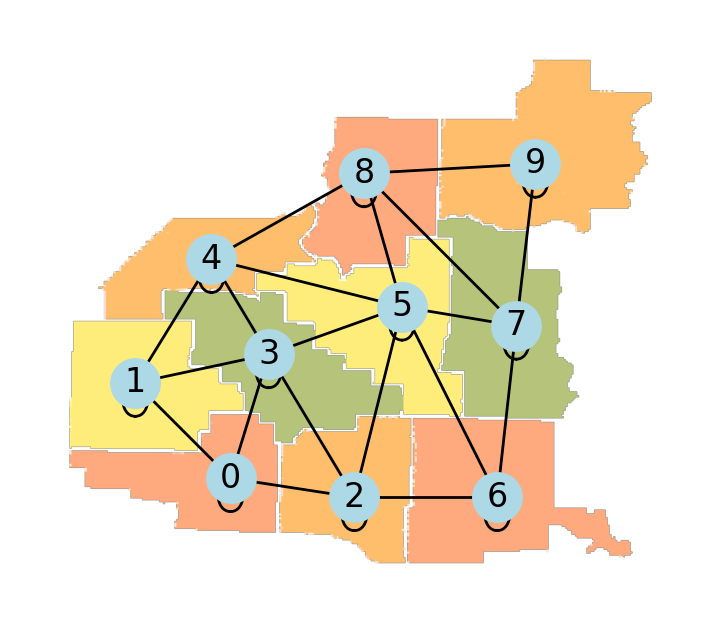

In [2]:
plt.figure(dpi=200)
img = mpimg.imread('Map.png')
imgplot = plt.imshow(img)

nodes_loc = np.array([(110,240),
                      (60,190),
                     (175,250),
                     (130,175),
                     (100,125),
                     (200,150),
                     (250,250),
                     (260,160),
                     (180,80),
                     (270,75)])

plt.scatter(nodes_loc[:,0],nodes_loc[:,1])
    
G = nx.Graph()

G.add_edges_from([(i,i) for i in range(len(nodes_loc))])
G.add_edges_from([(0,1),
                 (0,2),
                 (0,3),
                 (1,3),
                 (1,4),
                 (2,3),
                 (2,5),
                 (2,6),
                 (3,4),
                 (3,5),
                 (4,5),
                 (4,8),
                 (5,6),
                 (5,7),
                 (5,8),
                 (6,7),
                 (7,8),
                 (7,9),
                 (8,9)])
nx.draw(G,pos = nodes_loc,node_color='lightblue',labels={i:i for i in range(len(nodes_loc))})
    

# nx.draw(G,pos = nodes_loc,node_color='deepskyblue',node_size=12)
    
# plt.savefig('network.png')
plt.show()

In [3]:
def visit_all_nodes(gb):
    n_nodes  = len(gb.G)
    while True:
        unvisited = [i for i in range(n_nodes) if gb.nodes[i]['n_visits']==0]
        
        if len(unvisited)==0:
            break

        dest = unvisited[0]
        
        next_path = nx.shortest_path(gb.G,gb.state,dest)
        if len(next_path)==1:
            gb.step(dest)
        else:
            for s in next_path[1:]:
                gb.step(s)


def get_ucb(gb,nodes=None):
    
    if nodes is None:
        nodes = gb.nodes
    ave_reward = [np.mean(gb.nodes[i]['r_hist']) for i in nodes] 
    nm = [gb.nodes[i]['n_visits'] for i in nodes]
    
    tm = len(gb.visitedStates)
    ucb = ave_reward + np.sqrt(2*np.log(tm)/nm)
    
    return ucb


def get_ucb_Q_table(gb):
     
    ucb = get_ucb(gb)
    
    gap = np.sort(list(set(ucb)))[-1]-np.sort(list(set(ucb)))[-2]

    TG = nx.diameter(gb.G)*np.max(ucb)/gap

    Q,k, _ = get_Q_table(gb.G,ucb,TG)
    return Q


def train_agent(n_samples,T,G,means,init_node,execute_agent):
    rewards = np.zeros((n_samples,T))
    regrets = np.zeros((n_samples,T))
    for i in trange(n_samples):

        env = graph_bandit_RL.GraphBandit(means[i], G)

        ## Visit all nodes
        visit_all_nodes(env)

        H0 = len(env.visitedStates)

        # Start learning

        env.state = init_node

        while len(env.visitedStates)-H0<T:
            execute_agent(env)
            
        # print(env.visitedStates.shape,regrets.shape)
            
        rewards[i,:]= env.collected_rewards[:T]
        regrets[i,:]= env.expectedRegret()[:T]
        
    return rewards,regrets

In [4]:
def doubling_agent(env):
    ucb = get_ucb(env)
    # Compute Q table.
    Q = get_ucb_Q_table(env)

    # Travel to the node with the highest UCB
    while ucb[env.state] < np.max(ucb):
        next_s = np.argmax(Q[env.state,:])
        env.step(next_s)

    target_count = 0+env.nodes[env.state]['n_visits']
    # Keep sampling the best UCB node until its number of samples doubles
    for _ in range(target_count):
        env.step(env.state)


### Define parameters

Define the following parameters:  
$\texttt{T}:$ game length  
$\texttt{n_samples}:$ number of games to run   
$\texttt{episodes}:$ number of episodes; Let this be 1 for now 
$\texttt{n_nodes}:$ number of nodes in graph. 
$\texttt{mu_size}:$ the node means are drawn as $\mu\sim \texttt{mu_size}\times \mathcal{N}(0,1)$   
$\texttt{sigma_size}:$ the node standard deviations are set to $\texttt{sigma_size}$ 
$\texttt{epsilon}:$ exploration parameter (only applicable for Q-learning algorithms)  
$\texttt{epsilon_discount}:$ exploration discount parameter (only applicable for Q-learning algorithms)  
$\texttt{algorithms}:$ the algorithms to run. 


 



In [5]:
T = 2000
n_samples = 100
episodes = 1
# G = return_graph('line',10)
n_nodes = len(G)
mu_size = 1
sigma_size = 1

# For Q-learning

epsilon = 0.9
epsilon_discount=0.99

init_node = 0

In [6]:
# means = np.random.normal(size=(n_samples,n_nodes))
np.random.seed(SEED)
means = np.random.uniform(low=0.5,high=9.5,size=(n_samples,n_nodes))

In [7]:
rewards = {}
regrets = {}

In [8]:
rewards['Our Algorithm'],regrets['Our Algorithm'] = train_agent(n_samples,T,G,means,init_node,doubling_agent)


100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 16.71it/s]


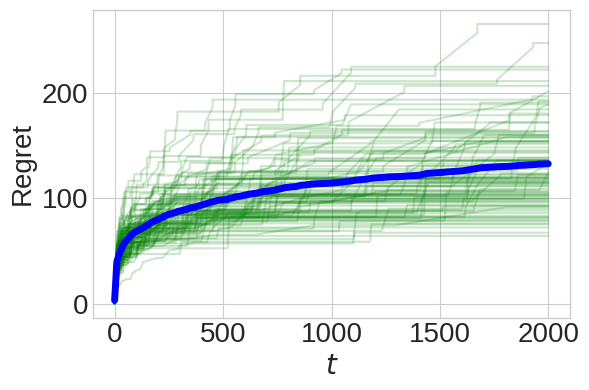

In [9]:
plt.figure(dpi=100)
plt.style.use('seaborn-whitegrid')
for i in range(100):
    plt.plot(np.cumsum(regrets['Our Algorithm'][i]),color='g',alpha=0.2)

plt.plot(np.mean(np.cumsum(regrets['Our Algorithm'],axis=1),axis=0),c='b',linewidth=5,linestyle='solid',alpha=1)
plt.xlabel(r'$t$', fontsize=20)
plt.ylabel('Regret', fontsize=20)
plt.tick_params(labelsize=20)
plt.tight_layout()
plt.savefig('Figures/ApplicationRegret.png')